In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import urllib
import requests
import time
import japanize_matplotlib
from sklearn.metrics import mean_squared_error
from scipy import stats as st
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import median_absolute_error
from sklearn.preprocessing import LabelEncoder
import pickle
import os
from optuna.integration import lightgbm as lgb


In [2]:
DIR = "./"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")
OUTPUT_SUB_DIR = os.path.join(OUTPUT_DIR,"submission")
OUTPUT_MODLE_DIR = os.path.join(OUTPUT_DIR,"model")
OUTPUT_OOF_DIR = os.path.join(OUTPUT_DIR,"oof")
OUTPUT_FEATURES_DIR = os.path.join(OUTPUT_DIR,"features")

for TMP_DIR in [OUTPUT_DIR, OUTPUT_SUB_DIR, OUTPUT_MODLE_DIR, OUTPUT_OOF_DIR, OUTPUT_FEATURES_DIR]:
    if not os.path.exists(TMP_DIR):
        os.makedirs(TMP_DIR)

In [3]:
class CFG:
    VER = 4
    AUTHOR = 'hisariki'
    MODEL_DATA_PATH = OUTPUT_MODLE_DIR
    OOF_DATA_PATH = OUTPUT_OOF_DIR
    METHOD_LIST = [
        'lightgbm',# 'xgboost', 'catboost', 'tabnet'
    ]
    seed = 42
    n_folds = 7
    target_col = 'attendance'
    group_col = 'home_team'
    metric = 'rmse'
    num_boost_round = 5000
    max_epochs = 2000
    early_stopping_rounds = 200
    verbose = 1000
    boosting_type = 'dart'
    lgb_params = {
      "objective":"regression",
      "metric":"rmse",
      'verbosity': -1,
      'n_jobs': -1,
      'boosting_type': boosting_type,
      "n_estimators": num_boost_round,
      "random_state": seed,
      'learning_rate': 0.05, 
      'lambda_l1': 0.0024306941353027622, 
      'lambda_l2': 1.0645884032063444e-08, 
      'num_leaves': 18, 
      'feature_fraction': 0.7168918229680646, 
      'bagging_fraction': 0.9476636054626689, 
      'bagging_freq': 1, 
      'max_depth': 15, 
      'max_bin': 272, 
      'min_data_in_leaf': 8
    }

    xgb_params = {
      "objective":'reg:squarederror',
      "metric":"rmse",
      "silent": 1,
      #'tree_method':'gpu_hist',
      "n_estimators":num_boost_round,
      "random_state":seed,
      'eta': 0.05, 
      'max_depth': 5, 
      'min_child_weight': 2, 
      'gamma': 2.4680517434774445e-05, 
      'subsample': 1.0, 
      'colsample_bytree': 0.7, 
      'colsample_bylevel': 0.5,
      "alpha":0.0,
      "lambda":1.0
    }
    
    ctb_params = {
    "verbose": verbose,
    "random_state": seed,
    "n_estimators": num_boost_round,
    "loss_function":"RMSE",
    "eval_metric":"RMSE",
    #"task_type":"GPU",
    "learning_rate":0.05
    }

def lgb_training(x_train: pd.DataFrame, y_train: pd.DataFrame, x_valid: pd.DataFrame, y_valid: pd.DataFrame,
                 features: list, categorical_features: list):
    clf = lgb.LGBMRegressor(**CFG.lgb_params)
    clf.fit(x_train, y_train,
                eval_set=[(x_valid, y_valid)],
                eval_metric=CFG.metric,
                verbose = CFG.verbose,
              #early_stopping_rounds=100,
              #categorical_feature = categorical_features
              )
    # Predict validation
    valid_pred = clf.predict(x_valid)
                     
    return clf, valid_pred

def xgb_training(x_train: pd.DataFrame, y_train: pd.DataFrame, x_valid: pd.DataFrame, y_valid: pd.DataFrame,
                 features: list, categorical_features: list):
    clf = xgb.XGBRegressor(**CFG.xgb_params)
    clf.fit(x_train, y_train,
                eval_set=[(x_valid, y_valid)],
                eval_metric=CFG.metric,
                verbose = CFG.verbose,
               early_stopping_rounds=CFG.early_stopping_rounds,
              #categorical_feature = categorical_features
              )
    # Predict validation
    valid_pred = clf.predict(x_valid)
    return clf, valid_pred

def ctb_training(x_train: pd.DataFrame, y_train: pd.DataFrame, x_valid: pd.DataFrame, y_valid: pd.DataFrame,
                 features: list, categorical_features: list):
    clf = CatBoostRegressor(**CFG.ctb_params)
    clf.fit(x_train, y_train,
          eval_set=[(x_train,y_train),(x_valid, y_valid)],
          early_stopping_rounds = CFG.early_stopping_rounds,
          use_best_model=True
          )
    # Predict validation
    valid_pred = clf.predict(x_valid)
    return clf, valid_pred

def tabnet_training(x_train: pd.DataFrame, y_train: pd.DataFrame, x_valid: pd.DataFrame, y_valid: pd.DataFrame,
                 features: list, categorical_features: list):
    clf = TabNetRegressor(verbose=CFG.verbose,seed=CFG.seed)
    y_train = np.log1p(y_train)
    y_valid = np.log1p(y_valid)
    clf.fit(X_train=x_train.to_numpy(), y_train=y_train.to_numpy().reshape(-1, 1),
              eval_set=[(x_valid.to_numpy(), y_valid.to_numpy().reshape(-1, 1))],
              patience=300, max_epochs=CFG.max_epochs,
              eval_metric=[CFG.metric])
    valid_pred = clf.predict(x_valid.to_numpy())
    valid_pred = np.expm1(valid_pred)
    return clf, valid_pred
    
    
def cv_training(method: str, train_df: pd.DataFrame, features: list, categorical_features: list):
    scores, preds = [],[]
    oof = pd.DataFrame()
    if method == 'lightgbm':
        lgb_importances = pd.DataFrame()
    kf = KFold(n_splits=CFG.n_folds ,shuffle=True, random_state=CFG.seed)
    for fold ,(tr_idx,va_idx) in enumerate(kf.split(train_df)):
        print("="*20,f" {method} training fold {fold + 1} ","="*20)
        
        train_folds = train_df.iloc[tr_idx]
        valid_folds = train_df.iloc[va_idx]
        x_train = train_folds[features]
        x_valid = valid_folds[features]
        y_train = train_folds[CFG.target_col]
        y_valid = valid_folds[CFG.target_col]
            
        if method == 'lightgbm':
            model, valid_pred = lgb_training(x_train, y_train, x_valid, y_valid, features, categorical_features)
            fi_tmp = pd.DataFrame()
            fi_tmp['feature'] = x_train.columns
            fi_tmp['importance'] = model.feature_importances_
            fi_tmp['fold'] = fold
            #変更点
            lgb_importances = []
            lgb_importances.append(fi_tmp)
            lgb_importances=pd.concat(lgb_importances)
        if method == 'xgboost':
            model, valid_pred = xgb_training(x_train, y_train, x_valid, y_valid, features, categorical_features)
        if method == 'catboost':
            model, valid_pred = ctb_training(x_train, y_train, x_valid, y_valid, features, categorical_features)
        if method == 'tabnet':
            model, valid_pred = tabnet_training(x_train, y_train, x_valid, y_valid, features, categorical_features)

        # Save best model
        pickle.dump(model, open(os.path.join(CFG.MODEL_DATA_PATH, f'{method}_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl'), 'wb'))
            

        score = np.sqrt(mean_squared_error(y_valid,valid_pred))
        print(f"RMSE : {score}")
        scores.append(score)
            
        valid_folds[f"{method}_pred"] = valid_pred
        
        oof = pd.concat([oof,valid_folds])
        
        del x_train,y_train,x_valid,y_valid
        
    print(f"Mean Score {np.mean(scores)}")
    
    oof.to_csv(os.path.join(CFG.OOF_DATA_PATH, f'oof_{method}_seed{CFG.seed}_ver{CFG.VER}.csv'), index = False)
    
    score = np.sqrt(mean_squared_error(oof["attendance"],oof[f"{method}_pred"]))
    print(f"RMSE : {score}")
    
    if method == 'lightgbm':
        order = list(lgb_importances.groupby('feature').mean().sort_values('importance', ascending=False).index)
        fig = plt.figure(figsize=(16, 32), tight_layout=True)
        sns.barplot(x="importance", y="feature", data=lgb_importances.groupby('feature').mean().reset_index(), order=order)
        plt.title("LightGBM feature importances")


def lgb_inference(x_test: pd.DataFrame):
    test_pred = np.zeros(len(x_test))
    for fold in range(CFG.n_folds):
        model = pickle.load(open(os.path.join(CFG.MODEL_DATA_PATH,f'lightgbm_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl'), 'rb'))
        # Predict
        test_pred += model.predict(x_test)
    return test_pred / CFG.n_folds
def xgb_inference(x_test: pd.DataFrame):
    test_pred = np.zeros(len(x_test))
    for fold in range(CFG.n_folds):
        model = pickle.load(open(os.path.join(CFG.MODEL_DATA_PATH,f'xgboost_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl'), 'rb'))
        # Predict
        test_pred += model.predict(x_test)
    return test_pred / CFG.n_folds
    
def ctb_inference(x_test: pd.DataFrame):
    test_pred = np.zeros(len(x_test))
    for fold in range(CFG.n_folds):
        model = pickle.load(open(os.path.join(CFG.MODEL_DATA_PATH,f'catboost_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl'), 'rb'))
        # Predict
        test_pred += model.predict(x_test)
    return test_pred / CFG.n_folds

def tabnet_inference(x_test: pd.DataFrame):
    test_pred = np.zeros(len(x_test))
    for fold in range(CFG.n_folds):
        model = pickle.load(open(os.path.join(CFG.MODEL_DATA_PATH, f'tabnet_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl'), 'rb'))
        # Predict
        test_pred += np.expm1(model.predict(x_test.to_numpy()))
    return test_pred / CFG.n_folds

def model_inference(method: str, test_df: pd.DataFrame, features: list, categorical_features: list):
    x_test = test_df[features]
    if method == 'lightgbm':
        test_pred = lgb_inference(x_test)
    if method == 'xgboost':
        test_pred = xgb_inference(x_test)
    if method == 'catboost':
        test_pred = ctb_inference(x_test)
    if method == 'tabnet':
        test_pred = tabnet_inference(x_test)
    return test_pred

def lgb_inference(x_test: pd.DataFrame):
    test_pred = np.zeros(len(x_test))
    for fold in range(CFG.n_folds):
        model = pickle.load(open(os.path.join(CFG.MODEL_DATA_PATH,f'lightgbm_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl'), 'rb'))
        # Predict
        test_pred += model.predict(x_test)
    return test_pred / CFG.n_folds
def xgb_inference(x_test: pd.DataFrame):
    test_pred = np.zeros(len(x_test))
    for fold in range(CFG.n_folds):
        model = pickle.load(open(os.path.join(CFG.MODEL_DATA_PATH,f'xgboost_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl'), 'rb'))
        # Predict
        test_pred += model.predict(x_test)
    return test_pred / CFG.n_folds
    
def ctb_inference(x_test: pd.DataFrame):
    test_pred = np.zeros(len(x_test))
    for fold in range(CFG.n_folds):
        model = pickle.load(open(os.path.join(CFG.MODEL_DATA_PATH,f'catboost_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl'), 'rb'))
        # Predict
        test_pred += model.predict(x_test)
    return test_pred / CFG.n_folds

def tabnet_inference(x_test: pd.DataFrame):
    test_pred = np.zeros(len(x_test))
    for fold in range(CFG.n_folds):
        model = pickle.load(open(os.path.join(CFG.MODEL_DATA_PATH, f'tabnet_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl'), 'rb'))
        # Predict
        test_pred += np.expm1(model.predict(x_test.to_numpy()))
    return test_pred / CFG.n_folds

def model_inference(method: str, test_df: pd.DataFrame, features: list, categorical_features: list):
    x_test = test_df[features]
    if method == 'lightgbm':
        test_pred = lgb_inference(x_test)
    if method == 'xgboost':
        test_pred = xgb_inference(x_test)
    if method == 'catboost':
        test_pred = ctb_inference(x_test)
    if method == 'tabnet':
        test_pred = tabnet_inference(x_test)
    return test_pred


In [4]:
holidays=pd.read_csv("holidays_in_japan.csv")
match=pd.read_csv("match_reports.csv")
sub_df=pd.read_csv("sample_submit.csv",header=None)
test=pd.read_csv("test.csv")
train=pd.read_csv("train.csv")
venue=pd.read_csv("venue_information.csv")
df=pd.concat([train,test],axis=0)

# 日時の処理

In [5]:
df["match_date"] = pd.to_datetime(df["match_date"], format="%Y-%m-%d")
df["kick_off_time"]=pd.to_datetime(df["kick_off_time"],format="%H:%M").dt.hour
df["month"]=pd.to_datetime(df["match_date"]).dt.month
df["year"]=pd.to_datetime(df["match_date"]).dt.year

In [6]:
df["capacity"]=np.nan
df=df.merge(venue[["venue","capacity","address"]],on="venue",how="left").drop("capacity_x",axis=1)

# wetherの処理

雨系かつ、【日産スタジアム,味の素スタジアム,万博記念競技場,ニッパツ三ツ沢球技場,京都市西京極総合運動公園陸上競技場兼球技場,広島ビッグアーチ,山梨中銀スタジアム,県立カシマサッカースタジアム,アウトソーシングスタジアム日本平,ユアテックスタジアム仙台,フクダ電子アリーナ,等々力陸上競技場,NACK5スタジアム大宮,ベストアメニティスタジアム,日立柏サッカー場,ヤマハスタジアム(磐田),名古屋市瑞穂陸上競技場】
の会場は少ない傾向

豊田スタジアムかつ屋内は多い傾向

In [7]:
df["weather"]=df["weather"].apply(lambda x:x[0] if "一時" or "時々" in x else x)
df["weather"]=df["weather"].apply(lambda x: "雨" if x=="霧" or x=="雷" or x=="雪"  else x)

In [8]:
df["rain"]=np.nan
df["rain"] = ((df["weather"] == "雨") & (df["venue"].isin(["日産スタジアム","味の素スタジアム","万博記念競技場","ニッパツ三ツ沢球技場","京都市西京極総合運動公園陸上競技場兼球技場","広島ビッグアーチ","山梨中銀スタジアム","県立カシマサッカースタジアム","アウトソーシングスタジアム日本平","ユアテックスタジアム仙台","フクダ電子アリーナ","等々力陸上競技場","NACK5スタジアム大宮","ベストアメニティスタジアム","日立柏サッカー場","ヤマハスタジアム(磐田)","名古屋市瑞穂陸上競技場"]))).astype(int)

In [9]:
df=df.drop("weather",axis=1)

# sectionは1節と34節が非常に多い roundは消去

In [10]:
df["first_end_sec"]=((df["section"]=="第1節")|(df["section"]=="第34節")).astype(int)

In [11]:
df=df.drop(["section","round"],axis=1)

# 放送局はtrainはスカパー、testはDAZNに代わっているので捨てる

In [12]:
for i,j in df["broadcasters"].value_counts().items():
    # print(i,j)
    pass

In [13]:
df=df.drop("broadcasters",axis=1)

# address の処理

In [14]:
import os
stadium_df = pd.read_csv("venue_information.csv")
stadium_df.columns = ["venue","capacity", "address"]
train = train.merge(stadium_df,how='left',on='venue')
test = test.merge(stadium_df,how='left',on='venue')

In [15]:
match_info_df = pd.concat([train,test],axis=0)
match_info_df = match_info_df[["id","match_date","home_team","away_team"]]

In [16]:
team_list, home_stadium_list = [],[]
lon, lat = [],[]
for team in list(df.home_team.unique()):
    home_stadium = pd.DataFrame(df.loc[df.home_team==team]["venue"].value_counts()).reset_index(names="index").iloc[0]["index"]
    team_list.append(team)
    home_stadium_list.append(home_stadium)

home_stadium_df = pd.DataFrame(data=[team_list, home_stadium_list]).T
home_stadium_df.columns = ["team","venue"]
home_stadium_df = home_stadium_df.merge(stadium_df, how = "left", on="venue")


In [17]:
makeUrl = "https://msearch.gsi.go.jp/address-search/AddressSearch?q="

df["home_team_stadium"] = "None"
df["home_team_address"] = "None"
df["home_team_capacity"] = np.nan
df["home_team_lon"] = np.nan
df["home_team_lat"] = np.nan
df["away_team_stadium"] = "None"
df["away_team_address"] = "None"
df["away_team_capacity"] = np.nan
df["away_team_lon"] = np.nan
df["away_team_lat"] = np.nan

for _, rows in home_stadium_df.iterrows():
    team = rows[0]
    stadium = rows[1]
    capacity = rows[2]
    address = rows[3]
    
    #　位置情報
    try:
        location = geocoder.osm(stadium, timeout=5.0)
        lat = location.latlng[0]
        lon = location.latlng[1]
    except:
        #team_city = re.sub(r"[^a-zA-Z]", "", team)
        #location =  geocoder.osm(team_city, timeout=5.0)
        s_quote = urllib.parse.quote(address)
        response = requests.get(makeUrl + s_quote)
        lat = response.json()[0]["geometry"]["coordinates"][1]
        lon = response.json()[0]["geometry"]["coordinates"][0]
        
    df.loc[df.home_team==team, "home_team_stadium"] = stadium
    df.loc[df.home_team==team, "home_team_address"] = address
    df.loc[df.home_team==team, "home_team_capacity"] = capacity
    df.loc[df.home_team==team, "home_team_lon"] = lon
    df.loc[df.home_team==team, "home_team_lat"] = lat
    
    df.loc[df.away_team==team, "away_team_stadium"] = stadium
    df.loc[df.away_team==team, "away_team_address"] = address
    df.loc[df.away_team==team, "away_team_capacity"] = capacity
    df.loc[df.away_team==team, "away_team_lon"] = lon
    df.loc[df.away_team==team, "away_team_lat"] = lat


In [18]:
df["stadium_distance"] = np.sqrt(np.square(df["home_team_lat"]-df["away_team_lat"])+np.square(df["home_team_lon"]-df["away_team_lon"]))

In [19]:
df ["venue"] = df.groupby ("capacity_y") ["venue"].transform (lambda x: x.mode () [0])
df ["address"] = df.groupby ("capacity_y") ["address"].transform (lambda x: x.mode () [0])

# homeのスタジアムで開催されているか否か

homeスタジアムじゃないかつvenueのキャパがhome_capaより大きいと、attendance大きくなる

In [20]:
df["is_home_stadium"]=np.where(df["venue"]==df["home_team_stadium"],1,0)

In [21]:
# df[(df["is_home_stadium"]==0) & (df["capacity_y"]<df["home_team_capacity"])]#0

In [22]:
# 条件に合う行を抽出する
cond = (df['is_home_stadium'] == 0) & (df['capacity_y'] > df['home_team_capacity'])
# is_home_stadiumの値を2に変更する
df.loc[cond, 'is_home_stadium'] = 2

In [23]:
df["is_home_stadium"].value_counts()

is_home_stadium
1    3381
2     339
0     105
Name: count, dtype: int64

In [24]:
# df.to_csv("./tableau_csv/is_home.csv")

# home awayのエンコーディング化

In [25]:
def get_label(df,home,away):
    le = LabelEncoder()
    df[home] = le.fit_transform(df[home])
    df[away] = le.transform(df[away])
    return df
get_label(df,"home_team","away_team")

,id,match_date,kick_off_time,home_team,away_team,venue,temperature,humidity,attendance,month,...,home_team_capacity,home_team_lon,home_team_lat,away_team_stadium,away_team_address,away_team_capacity,away_team_lon,away_team_lat,stadium_distance,is_home_stadium
0,9190,2006-03-04,16,2,20,万博記念競技場,8.3,40.0,20916.0,3,...,21000.0,135.540421,34.812466,埼玉スタジアム2002,埼玉県さいたま市緑区美園2丁目1,62010.0,139.713974,35.902477,4.313545,1
1,9191,2006-03-05,13,23,21,山梨中銀スタジアム,12.9,28.0,14277.0,3,...,15859.0,138.588425,35.620750,IAIスタジアム日本平,静岡県静岡市清水区村松3880−1,20248.0,138.482101,34.984898,0.644680,1
2,9192,2006-03-05,13,1,7,味の素スタジアム,12.1,35.0,22531.0,3,...,48999.0,139.528900,35.663670,九州石油ドーム,大分県大分市横尾1351,31997.0,131.656387,33.201115,8.248675,1
3,9193,2006-03-05,14,24,26,エコパスタジアム,11.6,42.0,28564.0,3,...,15165.0,137.877701,34.723106,レベルファイブスタジアム,福岡県福岡市博多区東平尾公園2-1-1,22331.0,130.461426,33.586304,7.502896,2
4,9194,2006-03-05,14,6,0,名古屋市瑞穂陸上競技場,13.1,32.0,17199.0,3,...,20223.0,136.941589,35.124908,キンチョウスタジアム,大阪府大阪市東住吉区長居公園1-1,17892.0,135.516663,34.616272,1.512985,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3820,20893,2018-07-22,19,1,19,味の素スタジアム,32.0,62.0,NaN,7,...,48999.0,139.528900,35.663670,日産スタジアム,神奈川県横浜市港北区小机町3300,72081.0,139.606674,35.510120,0.172123,1
3821,20894,2018-07-22,19,10,27,等々力陸上競技場,32.0,65.0,NaN,7,...,26827.0,139.648911,35.586826,トランスコスモススタジアム長崎,長崎県諫早市宇都町27−1,20258.0,130.038498,32.837368,9.995977,1
3822,20895,2018-07-22,19,2,21,市立吹田サッカースタジアム,31.2,50.0,NaN,7,...,21000.0,135.540421,34.812466,IAIスタジアム日本平,静岡県静岡市清水区村松3880−1,20248.0,138.482101,34.984898,2.946729,2
3823,20896,2018-07-22,19,0,20,大阪長居スタジアム,30.5,71.0,NaN,7,...,17892.0,135.516663,34.616272,埼玉スタジアム2002,埼玉県さいたま市緑区美園2丁目1,62010.0,139.713974,35.902477,4.389959,2


# 気温湿気の処理 気温はドロップした方が精度高い。　[気温、湿度]→[不快指数、湿度]

In [26]:
def discomfort_index(T, H):
    return 0.81*T+0.01*H*(0.99*T - 14.3) + 46.3
df["discomfort"] = discomfort_index(df["temperature"], df["humidity"])


# capacity_ratioの考え方

In [27]:
# df=df.copy()
# df.loc[:,"capacity_ratio"]=df["attendance"]/df["capacity_y"]*100
# obj_cols = df.select_dtypes(include="object").columns
# df1=df.drop(obj_cols,axis=1)
# df1=df1.drop(["capacity_y","attendance","id","match_date"],axis=1)

In [28]:
# train_df=df1[df1["capacity_ratio"].notnull()]
# test_df=df1[df1["capacity_ratio"].isnull()]
# train_df.to_csv("team_player_analysys.csv")

In [29]:
# train_x=train_df.drop("capacity_ratio",axis=1)
# train_y=train_df["capacity_ratio"]
# test_x=test_df.drop("capacity_ratio",axis=1)
# test_y=test_df["capacity_ratio"]

# capacity_yの考え方

In [30]:
# obj_cols = df.select_dtypes(include="object").columns
# df1=df.drop(["id","match_date"],axis=1)
# df1=df1.drop(obj_cols,axis=1)

# 説明変数の最終調整

In [31]:
df=df.drop(["id","match_date","venue","address","home_team_stadium","home_team_address","home_team_lon","home_team_lat","away_team_lon","away_team_lat","away_team_address","away_team_stadium"],axis=1)

In [32]:
df1=df.copy()

In [33]:
train_df=df1[df1["attendance"].notnull()]
test_df=df1[df1["attendance"].isnull()]

In [34]:
train_x=train_df.drop("attendance",axis=1)
train_y=train_df["attendance"]
test_x=test_df.drop("attendance",axis=1)
test_y=test_df["attendance"]

# LightGBM

In [35]:
def cv_training(method: str, train_df: pd.DataFrame, features: list, categorical_features: list):
    scores, preds = [],[]
    oof = pd.DataFrame()
    if method == 'lightgbm':
        lgb_importances = pd.DataFrame()
    #変化加えましたn_splitsに
    kf = KFold(n_splits=7 ,shuffle=True, random_state=CFG.seed)
    for fold ,(tr_idx,va_idx) in enumerate(kf.split(train_df)):
        print("="*20,f" {method} training fold {fold + 1} ","="*20)        
        train_folds = train_df.iloc[tr_idx]
        valid_folds = train_df.iloc[va_idx]
        x_train = train_folds[features]
        x_valid = valid_folds[features]
        y_train = train_folds[CFG.target_col]
        y_valid = valid_folds[CFG.target_col]
            
        # if method == 'lightgbm':
        model, valid_pred = lgb_training(x_train, y_train, x_valid, y_valid, features, categorical_features)
        fi_tmp = pd.DataFrame()
        fi_tmp['feature'] = x_train.columns
        fi_tmp['importance'] = model.feature_importances_
        fi_tmp['fold'] = fold
        #変更点
        lgb_importances = []
        lgb_importances.append(fi_tmp)
        lgb_importances=pd.concat(lgb_importances)
        # if method == 'xgboost':
        #     model, valid_pred = xgb_training(x_train, y_train, x_valid, y_valid, features, categorical_features)
        # if method == 'catboost':
        #     model, valid_pred = ctb_training(x_train, y_train, x_valid, y_valid, features, categorical_features)
        # if method == 'tabnet':
        #     model, valid_pred = tabnet_training(x_train, y_train, x_valid, y_valid, features, categorical_features)

        # Save best model
        pickle.dump(model, open(os.path.join(CFG.MODEL_DATA_PATH, f'{method}_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl'), 'wb'))
            

        score = np.sqrt(mean_squared_error(y_valid,valid_pred))
        print(f"RMSE : {score}")
        scores.append(score)
            
        valid_folds[f"{method}_pred"] = valid_pred
        
        oof = pd.concat([oof,valid_folds])
        
        del x_train,y_train,x_valid,y_valid
        
    print(f"Mean Score {np.mean(scores)}")
    
    oof.to_csv(os.path.join(CFG.OOF_DATA_PATH, f'oof_{method}_seed{CFG.seed}_ver{CFG.VER}.csv'), index = False)
    
    score = np.sqrt(mean_squared_error(oof["attendance"],oof[f"{method}_pred"]))
    print(f"RMSE : {score}")
    
    if method == 'lightgbm':
        order = list(lgb_importances.groupby('feature').mean().sort_values('importance', ascending=False).index)
        fig = plt.figure(figsize=(16, 32), tight_layout=True)
        sns.barplot(x="importance", y="feature", data=lgb_importances.groupby('feature').mean().reset_index(), order=order)
        plt.title("LightGBM feature importances")

In [36]:
from sklearn.model_selection import train_test_split,KFold,GroupKFold
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.3, random_state=42)

In [37]:
features=train_x.columns
categorical_features=["home_team","away_team"]

In [38]:
cv_training("lightgbm", train_df, features, categorical_features)

====================  lightgbm training fold 1  ====================


C:\Users\zekus\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\optuna\integration\_lightgbm_tuner\sklearn.py:42: UserWarning: LightGBMTuner doesn't support sklearn API. Use `train()` or `LightGBMTuner` for hyperparameter tuning.
  warnings.warn(


RuntimeError: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'optuna.integration._lightgbm_tuner.sklearn.LGBMRegressor'> with constructor (self, *args: Any, **kwargs: Any) -> None doesn't  follow this convention.

In [83]:
flag = 0
for method in CFG.METHOD_LIST:
    if flag==0:
        oof_df = pd.read_csv(os.path.join(CFG.OOF_DATA_PATH, f'oof_{method}_seed{CFG.seed}_ver{CFG.VER}.csv'))
        oof_df = pd.concat([train["id"],oof_df[[f"{method}_pred", "attendance"]]],axis=1)
        print(oof_df)
    else:
        tmp_df = pd.read_csv(os.path.join(CFG.OOF_DATA_PATH, f'oof_{method}_seed{CFG.seed}_ver{CFG.VER}.csv'))
        tmp_df = tmp_df[["id", f"{method}_pred"]]
        oof_df = oof_df.merge(tmp_df[["id", f"{method}_pred"]], how="left", on="id")
    flag=1

#oof_df["pred"] = 0.4 * oof_df['lightgbm_pred'] + 0.2 * oof_df['xgboost_pred'] + 0.35 * oof_df['catboost_pred'] + 0.05 * oof_df["tabnet_pred"]
oof_df["pred"] = oof_df['lightgbm_pred']  
score = np.sqrt(mean_squared_error(oof_df["attendance"],oof_df["pred"]))
print(f"RMSE : {score}")   

         id  lightgbm_pred  attendance
0      9190   20605.262106     20916.0
1      9191   16612.638891     17564.0
2      9192   11477.613880     13054.0
3      9193   10136.466026      7921.0
4      9194   23992.450130     30561.0
...     ...            ...         ...
3361  18195   18523.923558     23290.0
3362  18196   11386.014483     11883.0
3363  18197   14316.600310     16676.0
3364  18198   14178.650528     12377.0
3365  18199   13968.008301     13042.0

[3366 rows x 3 columns]
RMSE : 4299.167773116641


4211くらい

In [51]:
for method in CFG.METHOD_LIST:
    test_df.loc[:,f'{method}_pred'] = model_inference("lightgbm", test_df, features, categorical_features)

C:\Users\zekus\AppData\Local\Temp\ipykernel_7872\4053586511.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.loc[:,f'{method}_pred'] = model_inference("lightgbm", test_df, features, categorical_features)


In [52]:
#test_df['attendance'] = 0.4 * test_df['lightgbm_pred'] + 0.2 * test_df['xgboost_pred'] + 0.35 * test_df['catboost_pred'] + 0.05 * test_df["tabnet_pred"] 
test_df.loc[:,'attendance'] = test_df['lightgbm_pred']

In [53]:
sub_df.loc[:,1]=test_df["attendance"].values
sub_df.to_csv(os.path.join(OUTPUT_SUB_DIR,f"submission_exp{CFG.VER}.csv"),index=False, header=False)


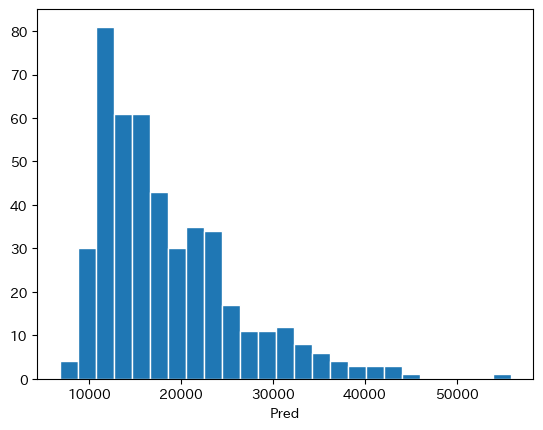

In [54]:
plt.hist(test_df.attendance,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

In [89]:
result_df=pd.read_csv("./output/oof/oof_lightgbm_seed42_ver4.csv")

In [96]:
result_df["diff"]=result_df["attendance"]-result_df["lightgbm_pred"]

<Axes: ylabel='diff'>

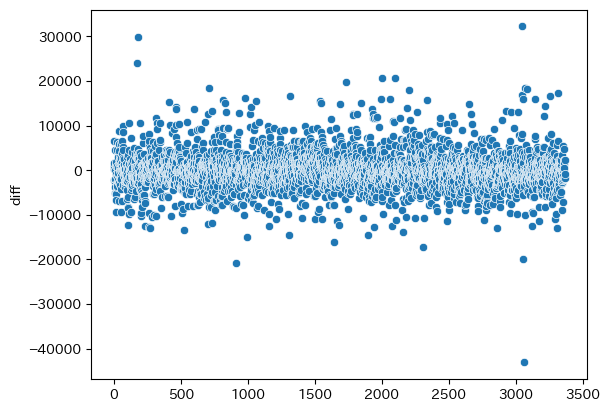

In [97]:
sns.scatterplot(x=result_df.index,y=result_df["diff"],data=result_df)

# 必要ない

In [ ]:
# SEED = 0
# import lightgbm as lgb

# params = {
#     "objective":"regression",
#       "metric":"rmse",
#       'verbosity': -1,
#       'n_jobs': -1,
#       'boosting_type': boosting_type,
#       "n_estimators": num_boost_round,
#       "random_state": seed,
#       'learning_rate': 0.05, 
#       'lambda_l1': 0.0024306941353027622, 
#       'lambda_l2': 1.0645884032063444e-08, 
#       'num_leaves': 18, 
#       'feature_fraction': 0.7168918229680646, 
#       'bagging_fraction': 0.9476636054626689, 
#       'bagging_freq': 1, 
#       'max_depth': 15, 
#       'max_bin': 272, 
#       'min_data_in_leaf': 8
# }

# model, valid_pred = lgb_training(X_train, y_train,X_val, y_val, features, categorical_features)

# train_data = lgb.Dataset(X_train, label=y_train)
# val_data = lgb.Dataset(X_val, label=y_val)

# model = lgb.train(
#     params,
#     train_data,
#     categorical_feature = cat_cols[3:],
#     valid_names = ['train', 'valid'],
#     valid_sets =[train_data, val_data],
#     verbose_eval=100


# )

# val_pred = model.predict(X_val, num_iteration=model.best_iteration)
# score = mean_squared_error(y_val, val_pred)

# pred_df = pd.DataFrame(sorted(zip(X_val.index, val_pred, y_val)))

# feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(), train_x.columns)), columns=['importance', 'feature'])

# print(f'score: {score:.4f}')

In [ ]:
# # feature importanceを表示
# importance = pd.DataFrame(model.feature_importance(), index=train_x.columns, columns=['importance'])
# display(importance.sort_values(by="importance"))

In [ ]:
pre_y=model.predict(test_x)

# 提出

In [ ]:
sub_df.loc[:,1]=pre_y

In [ ]:
sub_df.to_csv("submit.csv",index=None,header=None)

In [ ]:
# train.to_csv("object_train.csv")
# train,test=df[df["attendance"].notnull()],df[df["attendance"].isnull()]